In [1]:
# data stuff:
import pandas as pd
import numpy as np
import optuna
from sklearn.model_selection import TimeSeriesSplit

# plotting stuff:
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import Image

# stats stuff:
from sklearn.metrics import r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.regression.linear_model import yule_walker

# silence!
import warnings
warnings.filterwarnings("ignore")

---
## The ARMA Model:

The ARMA model is a simple combination of the AR and MA models.

See page 89 of "Advanced Forecasting with Python".

Model Definition:

$$X_{t}=c+\varepsilon_{t}+ \underbrace{\sum_{i=1}^{p} \varphi_{i} X_{t-i}}_{\text{AR model}} + \underbrace{\sum_{i=1}^{q} \theta_{i} \varepsilon_{t-i}}_{\text{MA model}}$$

---

### Import data:

In [2]:
sunspots_df = pd.read_csv('data/sunspots.csv', usecols=[1,2])
sunspots_df.head()

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


### Aggregate the data to use yearly counts instead:

In [3]:
sunspots_df['year'] = pd.to_datetime(sunspots_df['Date']).dt.year
sunspots_yearly = sunspots_df.groupby('year')['Monthly Mean Total Sunspot Number'].sum().to_frame()

In [4]:
sunspots_yearly.rename(columns={'Monthly Mean Total Sunspot Number': 'yearly sunspot count'}, inplace=True)
sunspots_yearly

,yearly sunspot count
year,
1749,1618.5
1750,1668.0
1751,953.3
1752,956.0
1753,613.5
...,...
2015,837.4
2016,477.9
2017,261.8


### Plot time-series:

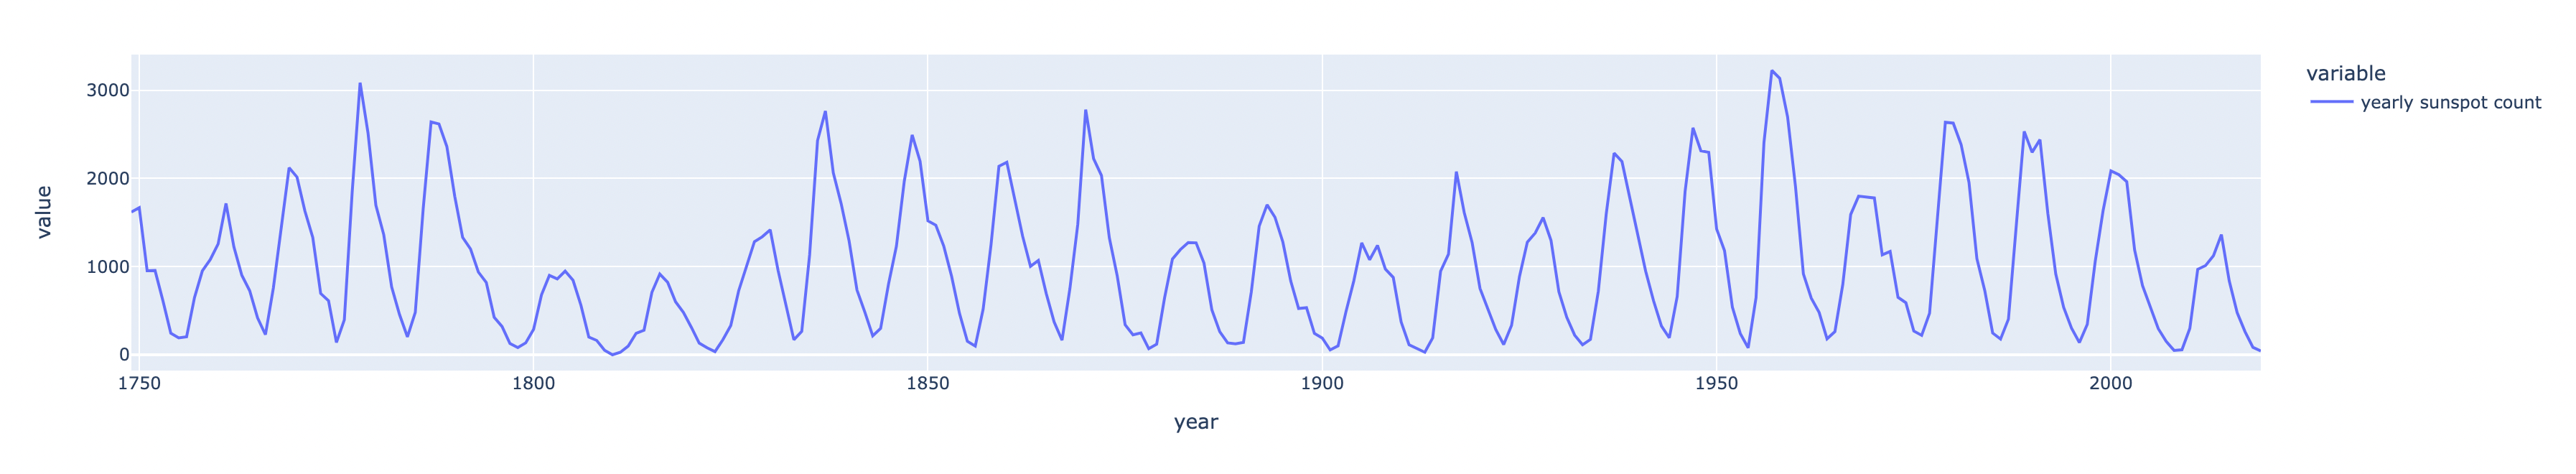

In [52]:
px.line(sunspots_yearly)
Image(filename='./images/ch5_rawseries.png', width=1600)

We can already see above that the data displays some seasonal trends, as there are peaks and valleys at regular intervals. We still need to check for stationarity.

### Check for stationarity using the Augmented Dicky-Fuller test:

In [6]:
# runs the Dicky-Fuller hypothesis test:
ADF_test = adfuller(sunspots_yearly['yearly sunspot count'])

# obtain p-value:
pvalue = ADF_test[1]


if pvalue < 0.05:
    print(f'p-value = {pvalue} ---> stationary')
else:
    print(f'p-value = {pvalue} ---> not stationary')

p-value = 0.059236973871616985 ---> not stationary


The test above fails for stationarity, which means that we cannot rely on the assumptions for AR and MA models without inspecting and processing further.

### Check the ACF and PACF plots to determine the model type:

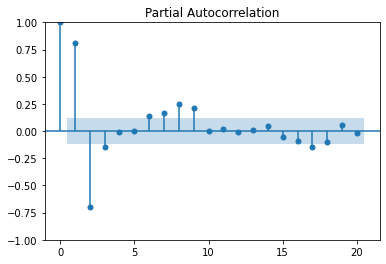

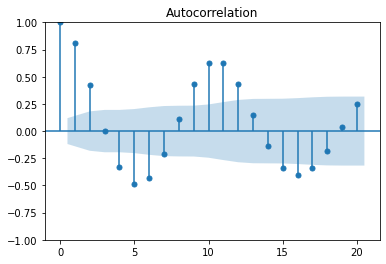

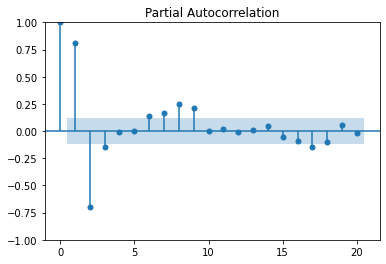

In [7]:
plot_acf(sunspots_yearly['yearly sunspot count'], lags=20)
plot_pacf(sunspots_yearly['yearly sunspot count'], lags=20)

&nbsp;

The criteria for selecting models above is as follows:

**AR Models are recognized by:**
* exponentially decaying partial autocorrelation (PACF)
* PACF decaying towards zero
* swings between positive and negative values in PACF

**MA Models are recognized by:**
* sudden spikes in the ACF and PACF

Given the plots above, we have enough evidence to ascertain that we are dealing with a AR model.

&nbsp;

### Fit an ARMA(1, 1) Model:
The model under consideration will be using an AR(1) and MA(1) (order 1 for both), which means that we will be using a single historical value to arrive at our predictions.

In [8]:
# define model:
arma_1_1 = ARIMA(list(sunspots_yearly['yearly sunspot count']), order=(1, 0, 1))

# fit:
result = arma_1_1.fit()

# predict on the historical patterns:
preds = result.predict()

# evaluate fit:
print(r2_score(sunspots_yearly['yearly sunspot count'], preds))

0.7609036836819467


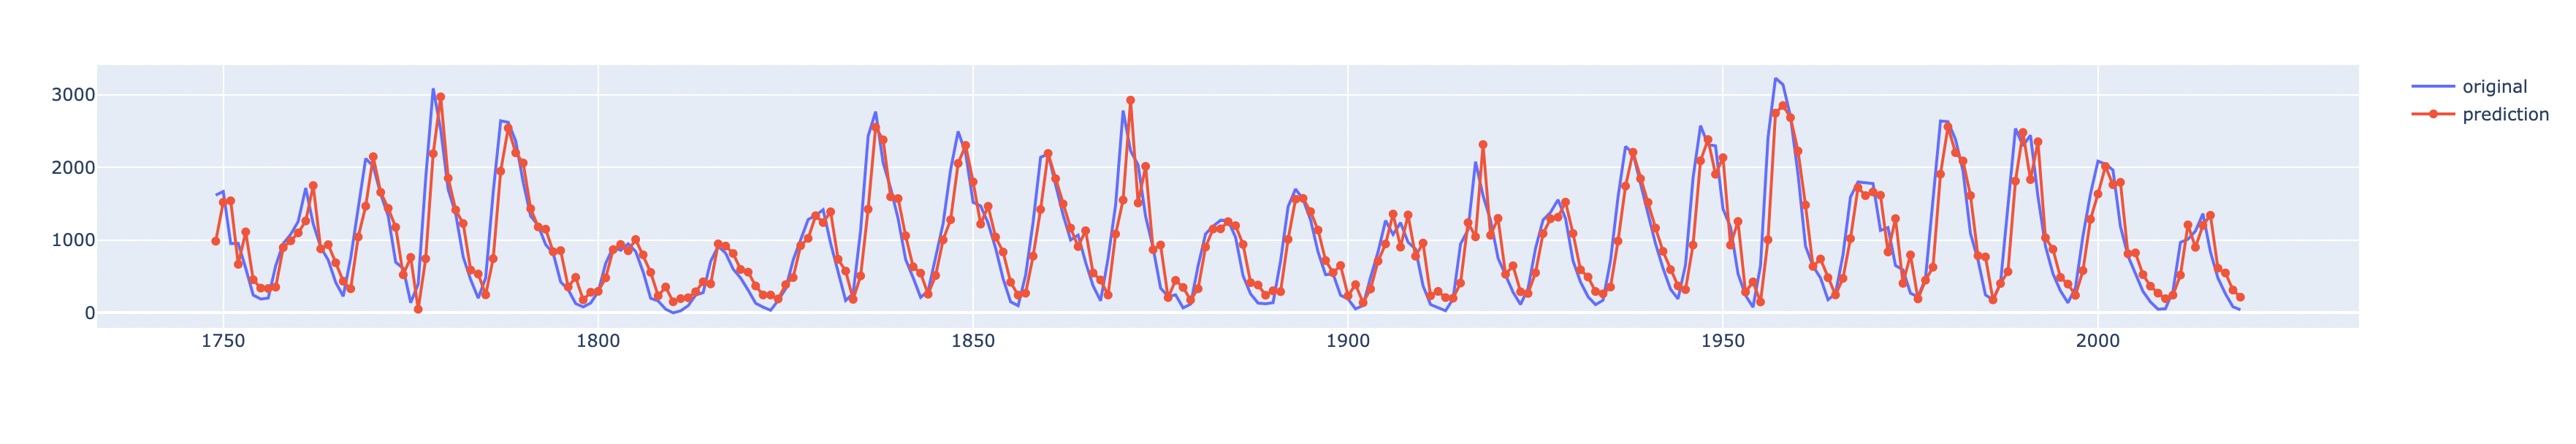

In [53]:
fig = go.Figure()
# original
fig.add_trace(go.Scatter(x=list(sunspots_yearly.index), y=sunspots_yearly['yearly sunspot count'], mode='lines', name='original'))

# predicted:
fig.add_trace(go.Scatter(x=list(sunspots_yearly.index), y=preds, mode='lines+markers', name='prediction'))
Image(filename='./images/ch5_fittedARMA.png', width=1600)

### Get model summary:

In [10]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  271
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1987.170
Date:                Mon, 06 Jun 2022   AIC                           3982.341
Time:                        14:16:28   BIC                           3996.749
Sample:                             0   HQIC                          3988.126
                                - 271                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        984.7442    153.327      6.423      0.000     684.229    1285.259
ar.L1          0.7193      0.051     14.024      0.000       0.619       0.820
ma.L1          0.5254      0.053      9.922      0.000       0.422       0.629
sigma2      1.361e+05   1.09e+04     12.479      0.000    1.15e+05    1.58e+05
===================================================================================
Ljung-Box (L1) (Q):                   8.44   Jarque-Bera (JB):                41.94
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.43   Skew:                             0.81
Prob(H) (two-sided):                  0.09   Kurtosis:                         4.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

&nbsp;

### Obtain and Plot residuals to inspect:
Below we plot the residuals in scatterplot and histogram to check for goodness of fit assumptions. According to the theory, residuals should be normally distributed. Also, the scattered residuals should not shown any trends or patterns.

Source: "Regression Analysis" by Jim Frost. Page 203 (OLS Assumptions)

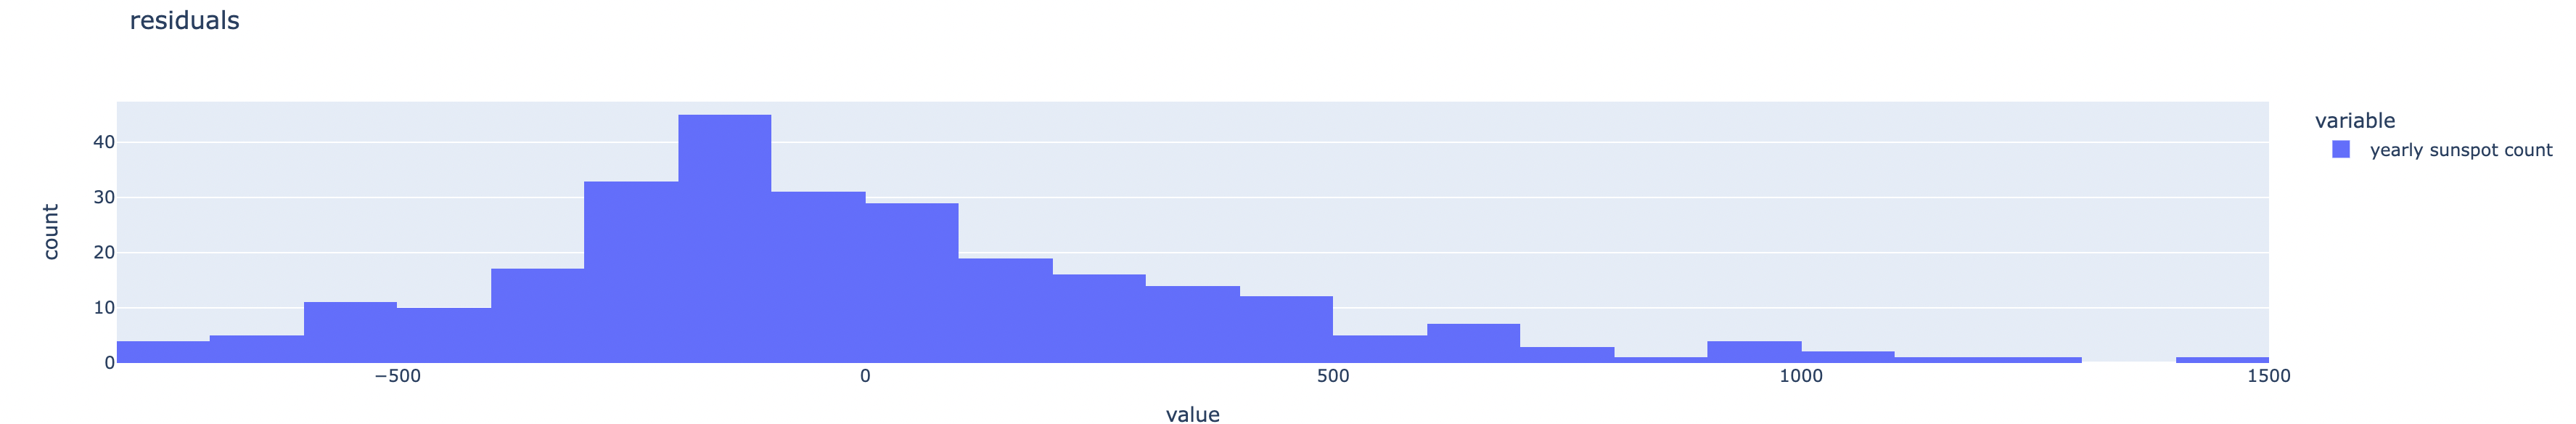

In [54]:
residuals = sunspots_yearly['yearly sunspot count'] - preds
px.histogram(residuals, title='residuals')
Image(filename='./images/ch5_residualhist.png', width=1600)

As we can see above, the residuals **do not follow a normal distribution**. This probably means that there are some lags to be added (which makes sense since the data displays a seasonality of 11 years).

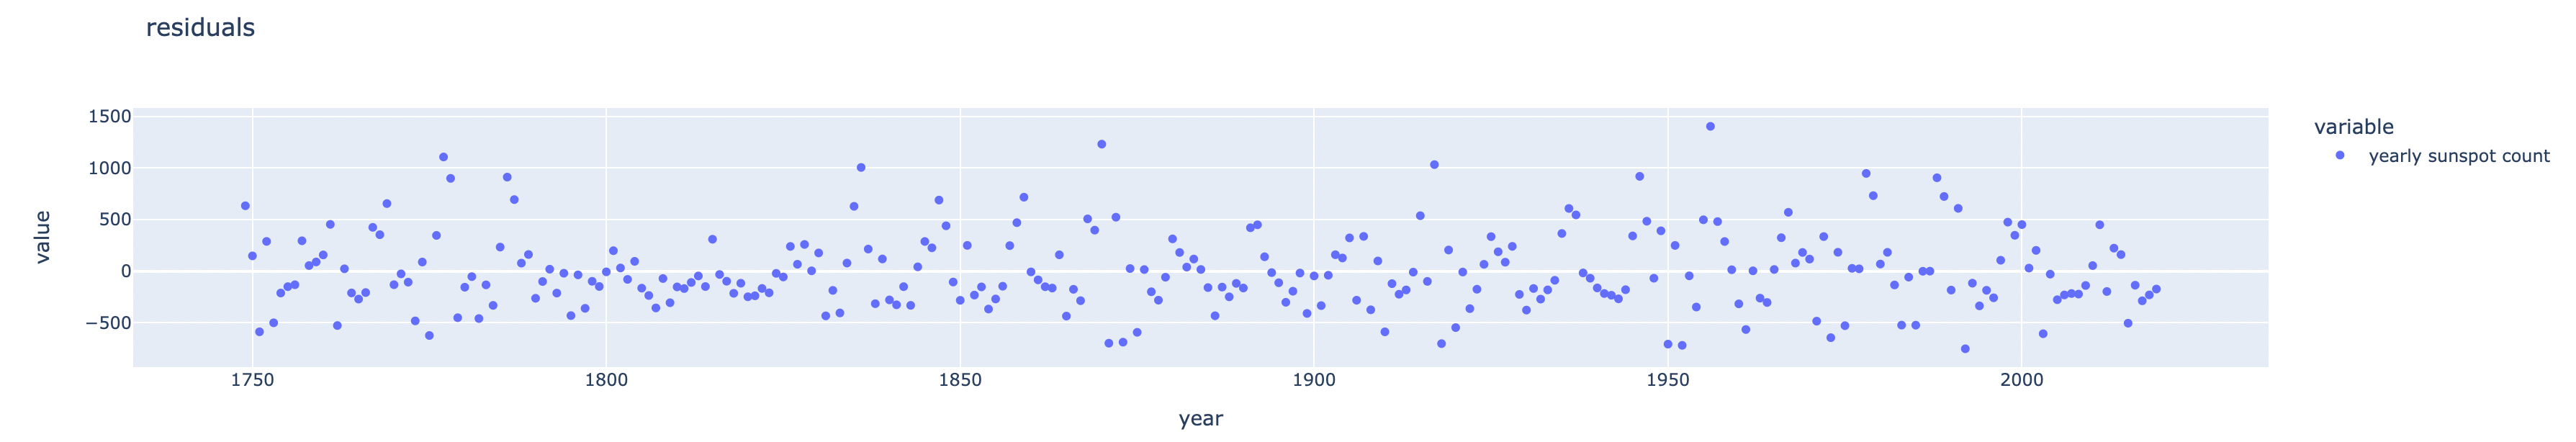

In [55]:
px.scatter(residuals, title='residuals')
Image(filename='./images/ch5_residualscatter.png', width=1600)

Again, the scatter plot for the residuals are displaying some of the same pattern found in the original data. 

&nbsp;

<div class="alert alert-block alert-info">
    
## Find optimal parameters (AR and MA orders) using Optuna:
    
</div>

### Define the objective function that will find the optimal parameters:

In [13]:
def objective_arma_cv(trial):
    # define search space for each model's order
    AR_order=trial.suggest_int('AR_order', 1, 13, step=1)
    MA_order=trial.suggest_int('MA_order', 1, 13, step=1)
    
    # define array of original values:
    data_array = sunspots_yearly['yearly sunspot count'].values
    
    # split data using folds
    tscv = TimeSeriesSplit(test_size=10)
    
    # define array to hold the score of each fold:
    scores = []
    
    # iterate through each fold:
    for train_index, test_index in tscv.split(data_array):
        
        # split into train and test:
        X_train, X_test = data_array[train_index], data_array[test_index]
        
        # initialize model and fit on the fold:
        model=ARIMA(X_train, order=(AR_order, 0, MA_order))
        mdl = model.fit()

        # predict on the fold:
        predictions = list(mdl.forecast(len(X_test)))

        # obtain residuals and evaluate using r-squared:
        score = r2_score(X_test, predictions)
        
        # append fold score to score array:
        scores.append(score)
        
    # obtain the mean r-squared score the folds:
    folds_score = np.mean(scores)

    return folds_score

### Run the optimization study:

In [14]:
# find optimal params (orders) that will maximize R-squared value:
study=optuna.create_study(direction="maximize")
study.optimize(objective_arma_cv, n_trials=25)

[I 2022-06-06 14:16:28,862] A new study created in memory with name: no-name-6bd40816-d06a-4530-a55d-4c129578f5f4
[I 2022-06-06 14:16:32,962] Trial 0 finished with value: 0.7599065335109043 and parameters: {'AR_order': 6, 'MA_order': 9}. Best is trial 0 with value: 0.7599065335109043.
[I 2022-06-06 14:16:38,122] Trial 1 finished with value: 0.7640724195441397 and parameters: {'AR_order': 10, 'MA_order': 9}. Best is trial 1 with value: 0.7640724195441397.
[I 2022-06-06 14:16:41,401] Trial 2 finished with value: 0.764488170591263 and parameters: {'AR_order': 8, 'MA_order': 6}. Best is trial 2 with value: 0.764488170591263.
[I 2022-06-06 14:16:45,282] Trial 3 finished with value: 0.7630287867648174 and parameters: {'AR_order': 7, 'MA_order': 8}. Best is trial 2 with value: 0.764488170591263.
[I 2022-06-06 14:16:48,468] Trial 4 finished with value: 0.7197902793346528 and parameters: {'AR_order': 13, 'MA_order': 1}. Best is trial 2 with value: 0.764488170591263.
[I 2022-06-06 14:16:50,616] 

### Obtain best parameters from the optimization study:

In [26]:
# optimal result and corresponding params:
trial=study.best_trial

# top r-squared value:
trial_value = np.round(trial.value, 2)

print(f"R-squared: {trial_value}")
print("best params for ARMA: {}".format(trial.params))

R-squared: 0.77
best params for ARMA: {'AR_order': 7, 'MA_order': 11}


In [21]:
trial.value

0.7699723500414947

&nbsp;

### Showing the test prediction of the final model:

In [50]:
# grab the best params from the study object:
AR_order = trial.params['AR_order']
MA_order = trial.params['MA_order']

# define array of original values
data_array = sunspots_yearly['yearly sunspot count'].values

# split:
X_train, X_test = data_array[:-10], data_array[-10:]
X_test_orig = X_test

# define array to hold forecasted values:
fcst = []

# iterate:
for step in range(len(X_test)):
    # intialize and fit:
    mod = ARIMA(X_train, order=(AR_order, 0, MA_order))
    res = mod.fit()
    
    # append forecast
    fcst.append(res.forecast(steps=1))
    
    # add forecasted value back into the train test (for MA model error calculation):
    X_train = np.concatenate((X_train, X_test[0:1]))
    X_test = X_test[1:]

### Plot best model forecast against ground truth:

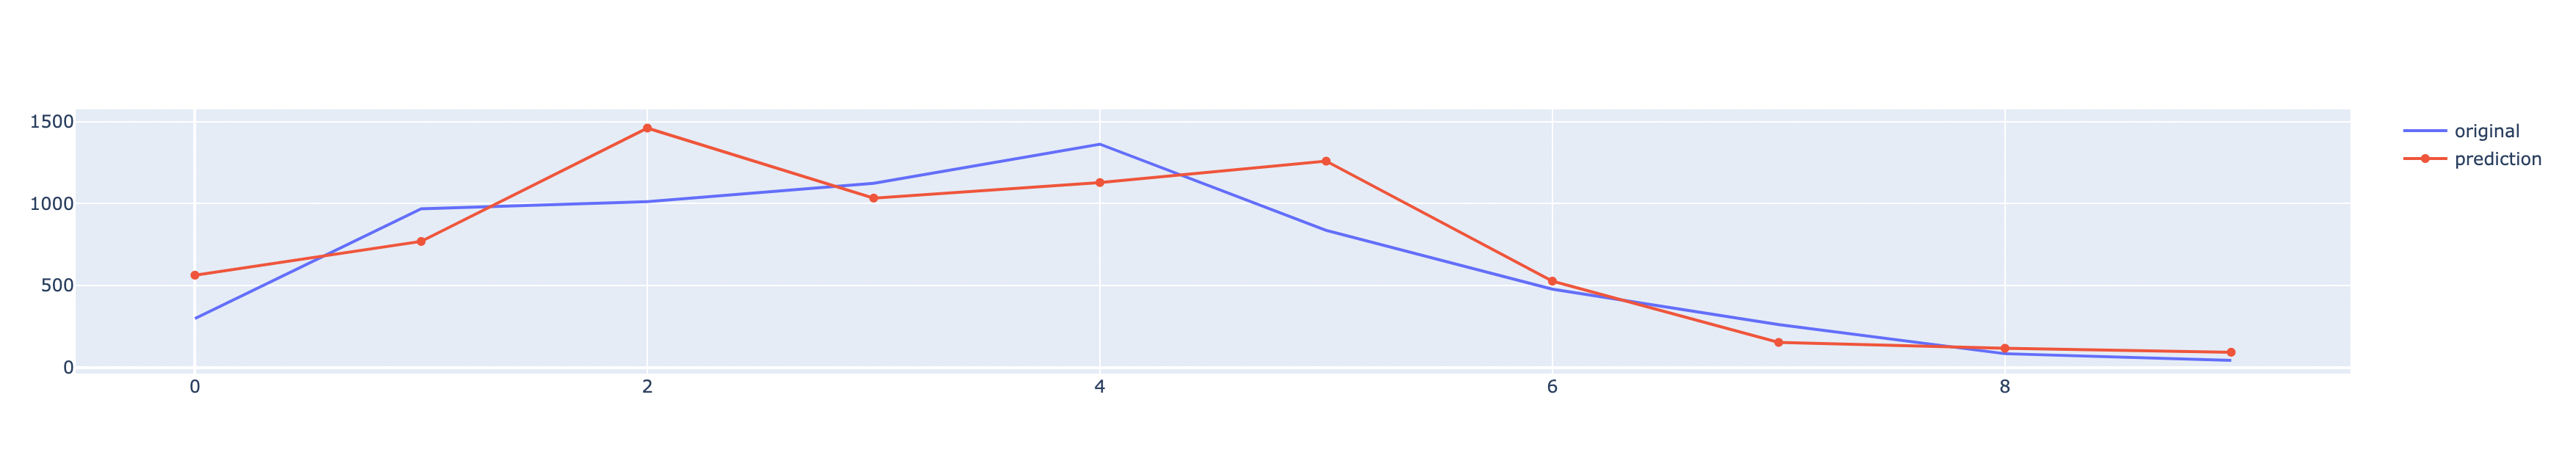

In [56]:
fig = go.Figure()
# original
fig.add_trace(go.Scatter(y=X_test_orig, mode='lines', name='original'))

# predicted:
fig.add_trace(go.Scatter(y=l, mode='lines+markers', name='prediction'))
Image(filename='./images/ch5_finalARMA.png', width=1600)